# ECG Classification Using Feature Extraction and Classical Machine Learning Approach

### Imports

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

# Import local Libraries
sys.path.insert(0, '/home/yardenas/ethz/courses_resources/\
                    advanced_machine_learning/ethz-advanced-ml/\
                    projects/project_3/classic_classification/\
                    ecg_features_master')
from ecg_features_master.features.features_submit import *

### Import the Data Set

In [3]:
path_to_data = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
X = pd.read_csv(path_to_data + '/X_train.csv').drop('id', axis=1).to_numpy()
y = pd.read_csv(path_to_data + '/y_train.csv').drop('id', axis=1).to_numpy()
X_end_test = pd.read_csv(path_to_data + '/X_test.csv').drop('id', axis=1).to_numpy()

In [4]:
np.count_nonzero(p.isnan(X)

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

### A Quick Look on the Data

Class distribution:  Counter({0: 3030, 2: 1474, 1: 443, 3: 170})
Data Dimensions:  (5117, 17813)
Label: N
Label: A
Label: O
Label: ~


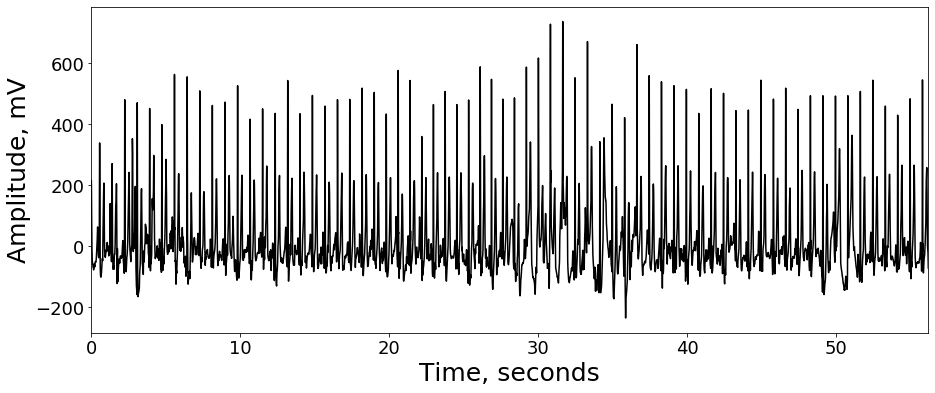

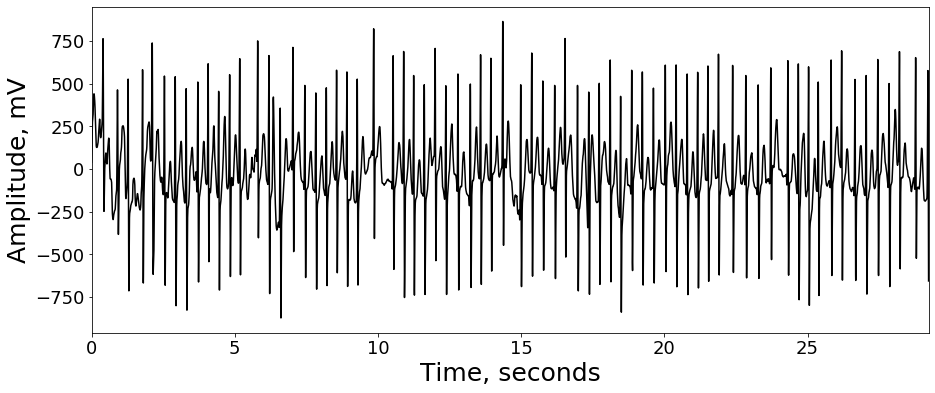

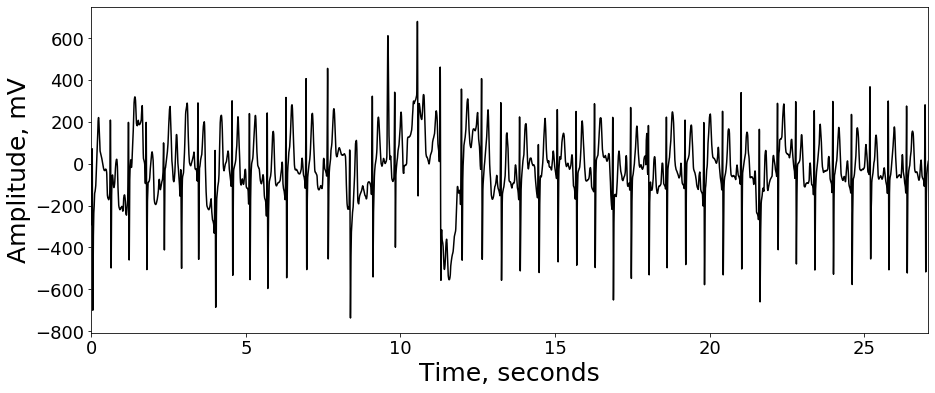

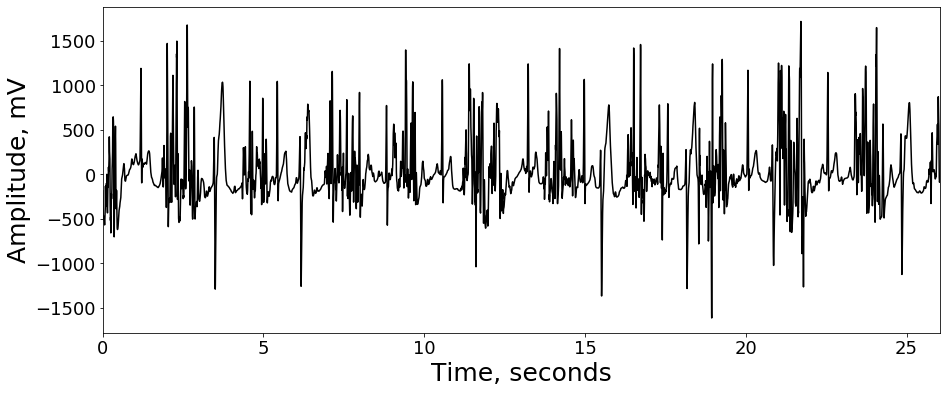

In [5]:
from ecg_features_master.utils.plotting.waveforms import plot_waveform
from collections import Counter
fs = 300 # [Hz]
print('Class distribution: ', Counter(y.ravel()))
print('Data Dimensions: ', X.shape)
labels = {
    'N': 0,
    'A': 1,
    'O': 2,
    '~': 3
}
for (heart, label_id) in labels.items():
    samples = X[np.argwhere(y == label_id)[0, 0], :]
    samples = samples[np.isfinite(samples)]
    print('Label: ' + heart)
    plot_waveform(samples, fs)

### Extract Features

In [10]:
ecg_features = FeaturesSubmit(
                    fs=fs,
                    feature_groups=[
                        'full_waveform_statistics'
                    ]
)
n_features = 49

In [11]:
training = np.empty((X.shape[0], n_features))
for idx, data_point in enumerate(X):
    data_point = data_point[np.isfinite(data_point)]
    ecg_features.calculate_features(
            data_point, 1, 
            filter_bandwidth=[3, 45], show=False,
            normalize=True, polarity_check=True,
            template_before=0.25, template_after=0.4
    )
    training[idx] = ecg_features.get_features().values

KeyboardInterrupt: 

In [9]:
test = np.empty((X_end_test.shape[0], n_features))
for idx, data_point in enumerate(X_end_test):
    data_point = data_point[np.isfinite(data_point)]
    ecg_features.calculate_features(
            data_point, 1, 
            filter_bandwidth=[3, 45], show=False,
            normalize=True, polarity_check=True,
            template_before=0.25, template_after=0.4
    )
    test[idx] = ecg_features.get_features().values

ValueError: could not broadcast input array from shape (49) into shape (315)

In [ ]:
print('Reliable Data: %0.4f' % (np.count_nonzero(~np.isnan(training)) / np.size(training)))

### Save the Features' Data

In [ ]:
id = [float(i) for i in range(0, len(training))]
feature_id = ['x' + str(i) for i in range(0, n_features)]
df_train = pd.DataFrame(training, id, feature_id)
df_train.index.name = 'id'
df_train.to_csv('training.csv', index=True)
id = [float(i) for i in range(0, len(test))]
df_test = pd.DataFrame(test, id, feature_id)
df_test.index.name = 'id'
df_test.to_csv('test.csv', index=True)

### Load the Features' Data

In [12]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from collections import Counter
path_to_data = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
training = pd.read_csv('training.csv', sep=None).drop('id', axis=1).to_numpy()
y = pd.read_csv(path_to_data + '/y_train.csv').drop('id', axis=1).to_numpy()
test = pd.read_csv('test.csv', sep=None).drop('id', axis=1).to_numpy()

/home/yardenas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  
/home/yardenas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
print('Class distribution: ', Counter(y.ravel()))
print('Data Dimensions: ', training.shape)
print('Reliable Data: %0.4f' % (np.count_nonzero(~np.isnan(training)) / np.size(training)))
print('Reliable Data: %0.4f' % (np.count_nonzero(~np.isnan(test)) / np.size(test)))
training

### Hyper-parameters Tuning and Cross-Validation


In [152]:
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import (GridSearchCV,
    cross_val_score, StratifiedKFold, KFold)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score

pipeline = make_pipeline(
                         SimpleImputer(strategy='median'),
                         RobustScaler(),
                         GradientBoostingClassifier()
)
parameter_space = {
    'gradientboostingclassifier__learning_rate': [0.1, 0.025],
    'gradientboostingclassifier__n_estimators': [500],
    'gradientboostingclassifier__subsample': [1., 0.5]
#     'gradientboostingclassifier__max_depth': [3, 5, 7]
}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True)
best_classifier = GridSearchCV(pipeline, parameter_space,
                               n_jobs=-1, scoring='f1_micro',
                               verbose=True, iid=False,
                               cv=inner_cv)
scores = cross_val_score(pipeline, training, y.ravel(),
                            cv=outer_cv,
                            scoring='f1_micro',
                            n_jobs=1,
                            verbose=True)
print("Cross-validation score is %0.4f, standart deviation is %0.4f" % (scores.mean(), scores.std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

### Training the Best Classifier

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Cross-validation score is 0.8013, standart deviation is 0.0118
Class distribution:  Counter({0: 3030, 2: 1474, 1: 443, 3: 170})
Prediction distribution:  Counter({0: 2374, 2: 739, 1: 241, 3: 57})


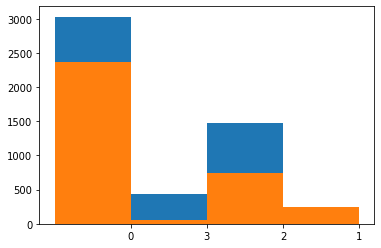

In [172]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(class_weight='balanced', y=y.ravel())
pipeline = make_pipeline(
                         SimpleImputer(strategy='median'),
                         RobustScaler(),
                         GradientBoostingClassifier(learning_rate=0.1, subsample=0.5)
)
scores = cross_val_score(pipeline, training, y.ravel(),
                            cv=outer_cv,
                            scoring='f1_micro',
                            n_jobs=-1,
                            verbose=True)
print("Cross-validation score is %0.4f, standart deviation is %0.4f" % (scores.mean(), scores.std()))
pipeline.fit(training, y.ravel())
y_pred = pipeline.predict(test)


print('Class distribution: ', Counter(y.ravel()))
print('Prediction distribution: ', Counter(y_pred.ravel()))
def counter_histogram(counter):
    labels, values = zip(*counter.items())
    indexes = np.arange(len(labels))
    width = 1
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
counter_histogram(Counter(y.ravel()))
counter_histogram(Counter(y_pred.ravel()))

id = [float(i) for i in range(0, len(y_pred))]
df = pd.DataFrame({'id': id, 'y': y_pred})
df.to_csv('solution.csv', index=False)

(3030,)
(443,)
(1474,)
(170,)


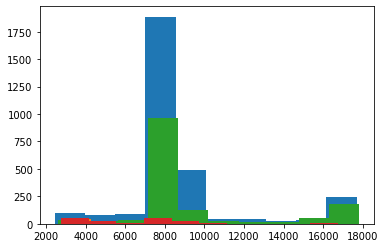

In [125]:
for (heart, label_id) in labels.items():
    samples = X[(y.ravel() == label_id)]
    print((samples.shape[1] - np.count_nonzero(np.isnan(samples), axis=1)).shape)
    plt.hist((samples.shape[1] - np.count_nonzero(np.isnan(samples), axis=1)))

In [150]:
sample_weights[y.ravel() == 0]

array([0.42219472, 0.42219472, 0.42219472, ..., 0.42219472, 0.42219472,
       0.42219472])